In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import os
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
import numpy as np
import io
from PIL import Image
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from ngboost import NGBClassifier
from ngboost.ngboost import NGBoost
from ngboost.learners import default_tree_learner
from ngboost.distns import Normal, LogNormal
from ngboost.distns import k_categorical
from sklearn.metrics import classification_report
from functools import partial
from rdkit.Chem import Draw
from IPython.display import SVG
plt.style.use('ggplot')

In [2]:
from rdkit.Chem import RDConfig

In [3]:
train = os.path.join(RDConfig.RDDocsDir, 'Book/data/solubility.train.sdf')
train_mols = [m for m in Chem.SDMolSupplier(train)]
test = os.path.join(RDConfig.RDDocsDir, 'Book/data/solubility.test.sdf')
test_mols = [m for m in Chem.SDMolSupplier(test)]

In [4]:
print(train_mols[0].GetPropsAsDict())

{'ID': 1, 'NAME': 'n-pentane', 'SOL': -3.18, 'SOL_classification': '(A) low', 'smiles': 'CCCCC'}


In [5]:
val_dict = {'(A) low':0,
           '(B) medium':1,
           '(C) high':2}

In [6]:
def mol2arr(mol, radi=2, nBits=1024):
    arr = np.zeros((1,))
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radi, nBits)
    DataStructs.ConvertToNumpyArray(fp, arr)

    return arr

In [7]:
trainX = np.array([mol2arr(m) for m in train_mols])
trainY = np.array([val_dict[m.GetProp('SOL_classification')] for m in train_mols])
trainY2 = np.array([np.float(m.GetProp('SOL')) for m in train_mols])

testX = np.array([mol2arr(m) for m in test_mols])
testY = np.array([val_dict[m.GetProp('SOL_classification')] for m in test_mols])
testY2 = np.array([np.float(m.GetProp('SOL')) for m in test_mols])

In [8]:
adbcls = AdaBoostClassifier()
svc = SVC(probability=True)
ngbc = NGBClassifier(Dist=k_categorical(3))
clsset = [adbcls, svc, ngbc]

In [9]:
for clsfier in clsset:
    clsfier.fit(trainX, trainY)

[iter 0] loss=1.0555 val_loss=0.0000 scale=2.0000 norm=6.8284
[iter 100] loss=0.8122 val_loss=0.0000 scale=1.0000 norm=2.7920
[iter 200] loss=0.7574 val_loss=0.0000 scale=1.0000 norm=2.6751
[iter 300] loss=0.7254 val_loss=0.0000 scale=1.0000 norm=2.6102
[iter 400] loss=0.7090 val_loss=0.0000 scale=0.5000 norm=1.2914


In [10]:
testres = []
for clsfier in clsset:
    res = clsfier.predict(testX)
    testres.append(res)
def mol2fp(mol, radi=2, nBits=1024):
    arr = np.zeros((1,))
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radi, nBits)
    return fp

In [11]:
from rdkit.Chem.Draw import SimilarityMaps
from functools import partial
#getfp = partial(SimilarityMaps.GetMorganFingerprint,nBits=1024)
fpfunc = partial(SimilarityMaps.GetMorganFingerprint, nBits=1024, radius=2)
# https://www.rdkit.org/docs/Cookbook.html
# Following example I would like to get probability of High solubility
def getProba(fp, predctionFunction):
    return predctionFunction(np.array([fp]))[0][2]

In [12]:
high_test_mols = [mol for mol in test_mols if mol.GetProp('SOL_classification') == '(C) high']
low_test_mols = [mol for mol in test_mols if mol.GetProp('SOL_classification') == '(A) low']


In [13]:
def drawmol(mols, idx, predictfunc):
    d = Draw.MolDraw2DCairo(1,1)
    d = Draw.MolDraw2DSVG(200,250)
    fig, maxWeight = SimilarityMaps.GetSimilarityMapForModel(mols[idx],fpfunc, 
                                                           lambda x: getProba(x, predictfunc.predict_proba),
                                                           draw2d = d,
                                                           colorMap='coolwarm', #this option wasn't applied why?? 
                                                           size=(100,100),
                                                           contourLines=0,
                                                           step=0.001,
                                                           alpha=0.2,
                                                           )
    d.FinishDrawing()
    txt = d.GetDrawingText()
    #img = show_png(d.GetDrawingText())
    return txt

In [14]:
class HorizontalDisplay:
    def __init__(self, svgtxtlist):
        self.svgtxtlist = svgtxtlist

    def _repr_html_(self):
        template = '<div style="float: left; padding: 10px;">{0}</div>'
        return "\n".join(template.format(svgtxt)
                         for svgtxt in self.svgtxtlist)

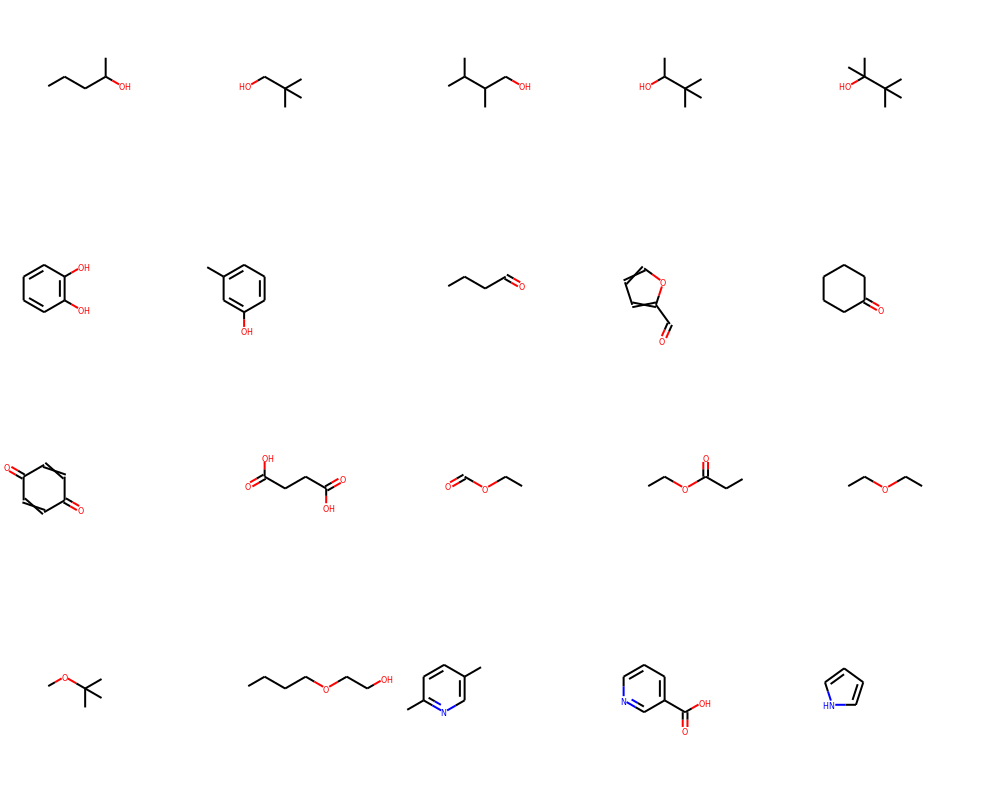

In [15]:
Draw.MolsToGridImage(high_test_mols[:20], molsPerRow=5)

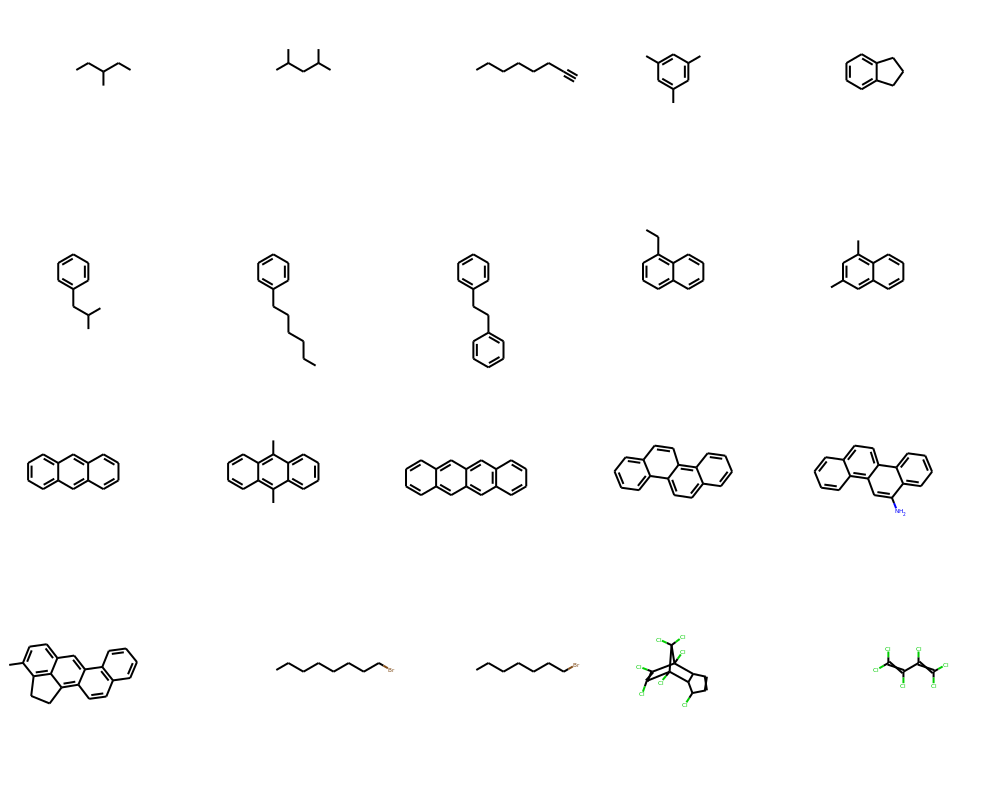

In [16]:
Draw.MolsToGridImage(low_test_mols[:20], molsPerRow=5)

In [17]:
#Adaboost, SVC, NGBOOST
svgset = []
for cls in clsset:
    svgset.append(drawmol(high_test_mols, 3, cls))
HorizontalDisplay(svgset)

In [18]:
#Adaboost, SVC, NGBOOST
svgset = []
for cls in clsset:
    svgset.append(drawmol(high_test_mols, 3, cls))
HorizontalDisplay(svgset)

In [19]:
#Adaboost, SVC, NGBOOST
svgset = []
for cls in clsset:
    svgset.append(drawmol(low_test_mols, 18, cls))
HorizontalDisplay(svgset)

In [20]:
#Adaboost, SVC, NGBOOST
svgset = []
for cls in clsset:
    svgset.append(drawmol(high_test_mols, 3, cls))
HorizontalDisplay(svgset)